In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
from sklearn.preprocessing import label_binarize
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#HELPER CODE

#Validation Method
def performValidation(model, data, realScores, aucName):
    #DT Accuracy
    print("*****DECISION TREE*****")
    y_pred = model.predictDTScoreSet(data)
    
    acc = accuracy_score(realScores,y_pred)
    recall = recall_score(realScores,y_pred,average='weighted')
    f1 = f1_score(realScores,y_pred,average='weighted')
    prec = precision_score(realScores,y_pred,average='weighted')
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)

    print("DT Accuracy:", acc)
    print("DT Recall:", recall)
    print("DT F1 Score:", f1)
    print("DT Precision:", prec)
    
    #MVDD Accuracy
    print("\n*****MVDD*****")
    y_pred = model.predictScoreSet(data)
    
    acc = accuracy_score(realScores,y_pred)
    recall = recall_score(realScores,y_pred,average='weighted')
    f1 = f1_score(realScores,y_pred,average='weighted')
    prec = precision_score(realScores,y_pred,average='weighted')
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)

    print("Accuracy:", acc)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Precision:", prec)
    
    return acc, recall, f1, prec

# ESCAPE training - Hemo - Death

In [3]:
#Load original dataframes
hemoData = pd.read_csv('Data/Preprocessed Data/ESCAPE_AC_Hemo.csv', index_col='ID')
allScores = hemoData['Score']
death = hemoData['ScoreDeath']
rehosp = hemoData['ScoreRehosp']
readm = hemoData['ScoreReadmission']
hemoData

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,4,5,4,2
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,4,5,4,2
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,5,4,5,3
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,5,4,5,3
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,5,4,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,2,1,2,4
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,5,4,5,3
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,5,4,5,3


In [4]:
# Preprocess and create training and testing sets
hemo = hemoData.drop('Score', axis=1)
hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

xData = hemo
yData = death
xData.shape, yData.shape

((418, 28), (418,))


Total edges: 12 Nonterminal Edge 5
Must have more than 2 and less than 3 OR Edges
Best edge set: ['dashed', 'dashed', 'dashed', 'solid', 'solid']
Accuracy DT: 0.9767441860465116
Accuracy MVDD: 0.6395348837209303


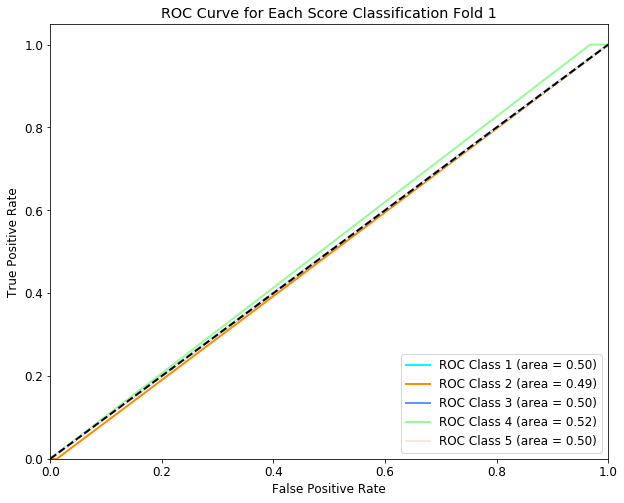


Total edges: 12 Nonterminal Edge 5
Must have more than 2 and less than 3 OR Edges
Best edge set: ['solid', 'solid', 'dashed', 'dashed', 'dashed']
Accuracy DT: 1.0
Accuracy MVDD: 0.9880952380952381


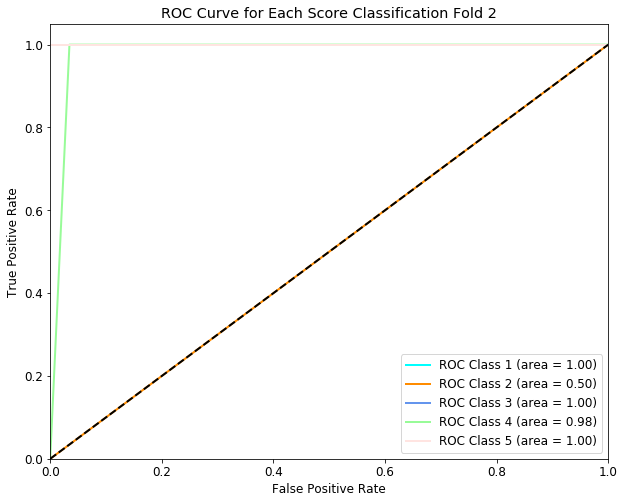


Total edges: 14 Nonterminal Edge 6
Must have more than 2 and less than 4 OR Edges
Best edge set: ['dashed', 'solid', 'dashed', 'dashed', 'solid', 'solid']
Accuracy DT: 0.9759036144578314
Accuracy MVDD: 0.9397590361445783


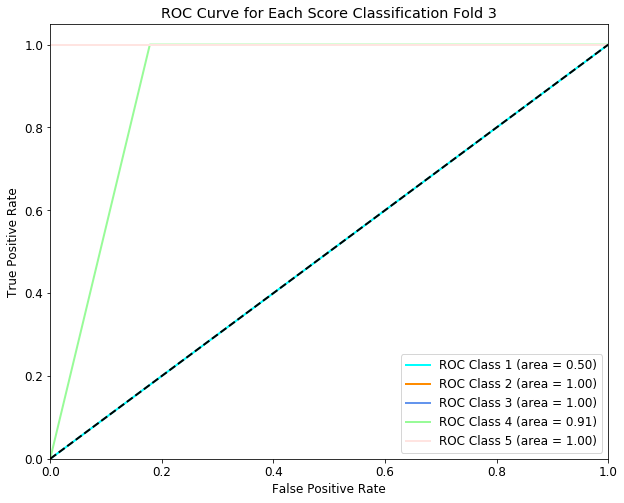


Total edges: 12 Nonterminal Edge 5
Must have more than 2 and less than 3 OR Edges
Best edge set: ['solid', 'solid', 'dashed', 'dashed', 'dashed']
Accuracy DT: 0.9879518072289156
Accuracy MVDD: 0.9879518072289156


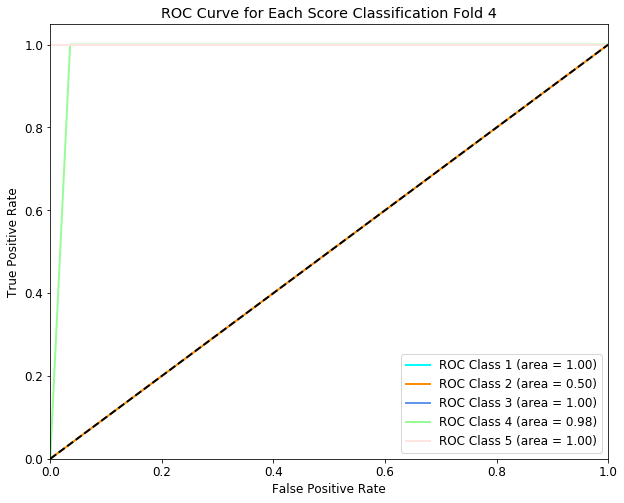


Total edges: 10 Nonterminal Edge 4
Must have more than 1 and less than 2 OR Edges
Best edge set: ['solid', 'solid', 'dashed', 'dashed']
Accuracy DT: 0.9878048780487805
Accuracy MVDD: 0.9878048780487805


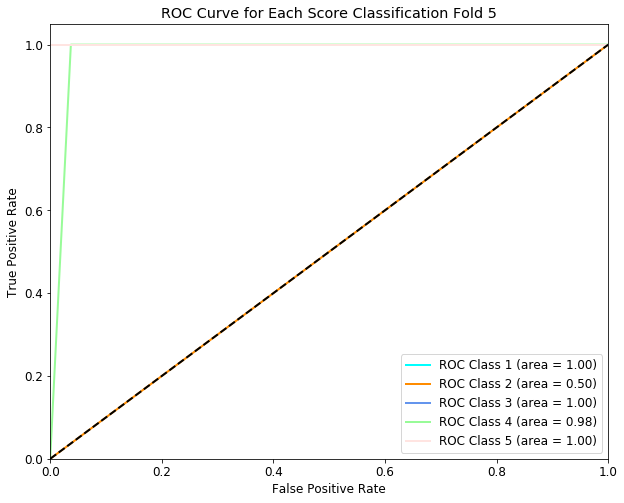

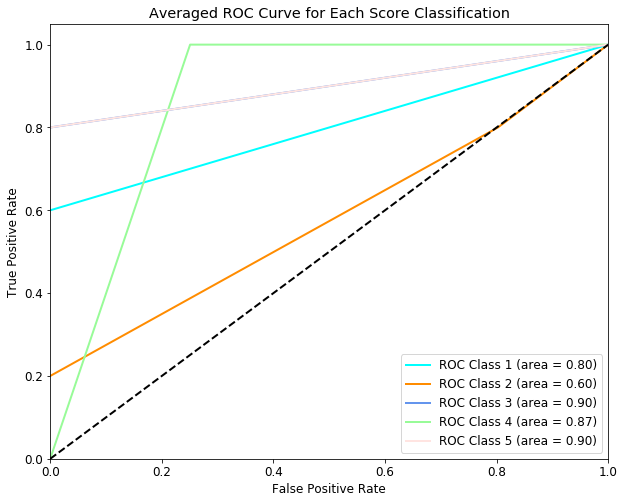

*****Averaged Final Classification Results*****
Accuracy: 0.909(+/- 0.272)
Precision: 0.845(+/- 0.437)
Recall: 0.909(+/- 0.272)
F1: 0.872(+/- 0.373)


In [5]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='AC_Hemo_Death', numFolds=5, 
                                        showIndividualROC=True)

## Cardiogenic Shock Validation

In [6]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_Hemo_Death')

*****DECISION TREE*****


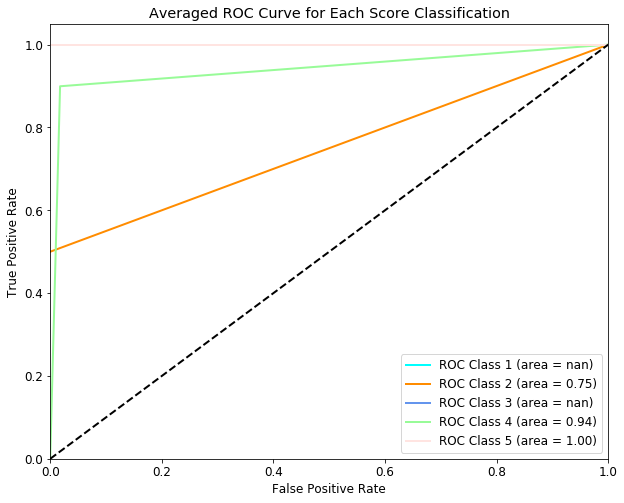

DT Accuracy: 0.9304635761589404
DT Recall: 0.9304635761589404
DT F1 Score: 0.9591794928240782
DT Precision: 0.9927229323887263

*****MVDD*****


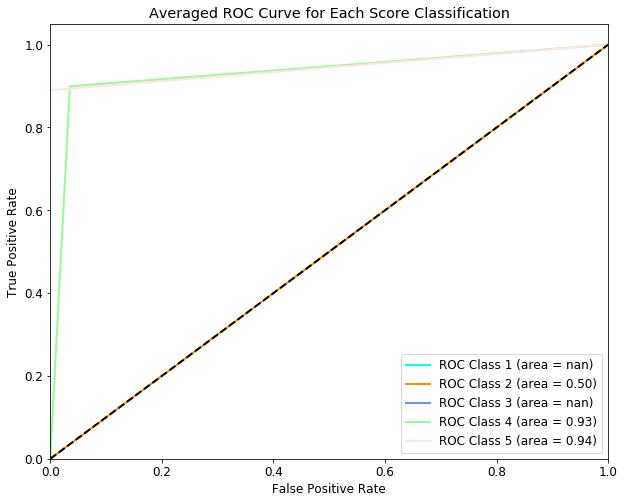

Accuracy: 0.8841059602649006
Recall: 0.8841059602649006
F1 Score: 0.9260770822030561
Precision: 0.972368120575474


In [7]:
hemoCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AC_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoCardShock')

## Serial Cardiac Validation

In [8]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_Hemo_Death')

*****DECISION TREE*****


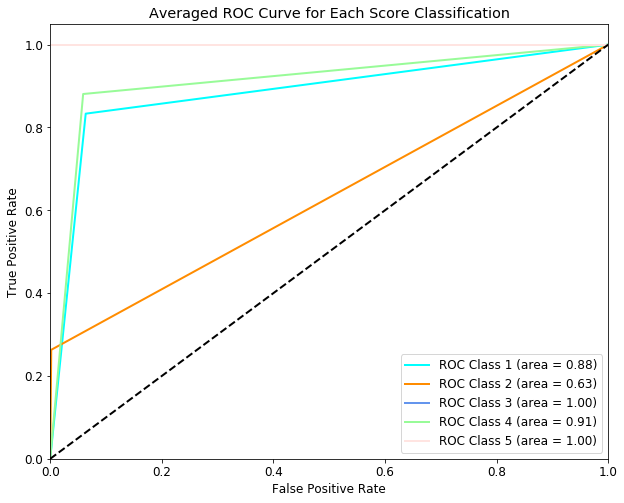

DT Accuracy: 0.908273381294964
DT Recall: 0.908273381294964
DT F1 Score: 0.9235356527962805
DT Precision: 0.9558675123957774

*****MVDD*****


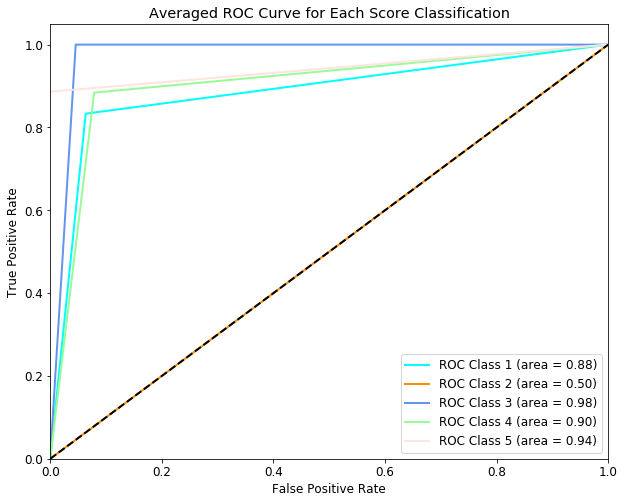

Accuracy: 0.8561151079136691
Recall: 0.8561151079136691
F1 Score: 0.8734144569780313
Precision: 0.906631397075412


In [9]:
hemoCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AC_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoSerialCardiac')

# ESCAPE Training - All Data - Death

In [10]:
#Load original dataframes
allData = pd.read_csv('Data/Preprocessed Data/ESCAPE_AC_AllData.csv', index_col='ID')
allScores = allData['Score']
death = allData['ScoreDeath']
rehosp = allData['ScoreRehosp']
readm = allData['ScoreReadmission']
allData

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
72.0,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,4,3,4,4
72.0,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,4,3,4,4
72.0,37.0,2.0,0.0,64.863709,0.000000,0.0,0.0,3.0,0.0,1.0,...,0.0,0.000000,118.000000,28.0,0.341463,0.411765,5,4,5,5
81.0,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,4,3,4,4
81.0,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,4,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302.0,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,4,3,4,4
99912.0,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,2,2,1,3
99912.0,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,2,2,1,3


In [11]:
# Preprocess and create training and testing sets
alld = allData.drop('Score', axis=1)
alld = alld.drop('ScoreDeath', axis=1)
alld = alld.drop('ScoreRehosp', axis=1)
alld = alld.drop('ScoreReadmission', axis=1)
alld = alld.replace(np.inf, 0)
alld = alld.fillna(0)

xData = alld
yData = death
xData.shape, yData.shape

((889, 66), (889,))

In [ ]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                        learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                        modelName='AC_AllData_Death', numFolds=5, 
                                        showIndividualROC=True)


Total edges: 182 Nonterminal Edge 90
Must have more than 27 and less than 54 OR Edges


# Cardiogenic Shock All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_AllData_Death')

In [ ]:
allDataCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AC_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataCardShock')

# Serial Cardiac All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_AllData_Death')

In [ ]:
allDataCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AC_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataSerialCardiac')

# HF-ACTION All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AC_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataHfaction')

# BEST All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AC_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataBest')

# GUIDE-IT All Data Validation

In [ ]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AC_AllData_Death')

In [ ]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AC_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
acc, recall, f1, prec = performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataGuideIt')